<a href="https://colab.research.google.com/github/GuiSamuka/DataScience-Airbnb-Rio/blob/main/Projeto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU PROCESSING - COLAB

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14972283885098728490, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9348023672157366946
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [3]:
!cat /proc/meminfo

MemTotal:       13333596 kB
MemFree:         9551864 kB
MemAvailable:   12047004 kB
Buffers:           79300 kB
Cached:          2415808 kB
SwapCached:            0 kB
Active:          1294276 kB
Inactive:        2065008 kB
Active(anon):     679364 kB
Inactive(anon):    10600 kB
Active(file):     614912 kB
Inactive(file):  2054408 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1396 kB
Writeback:             0 kB
AnonPages:        864176 kB
Mapped:           586476 kB
Shmem:             11272 kB
Slab:             184548 kB
SReclaimable:     133192 kB
SUnreclaim:        51356 kB
KernelStack:        5248 kB
PageTables:         8868 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666796 kB
Committed_AS:    3950388 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1048 kB
AnonHugePages:   

# Projeto de Data Science aplicado à dataset do Airbnb Rio
## Objetivo: criar um modelo que determine o preço do imóvel (considerando o brasileiro médio comum)

## 1 - Importar Bibliotecas e Bases de Dados

In [4]:
import pandas as pd # Manipulação de DataFrames e Series
import pathlib # Navegar entre pastas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

## 2 - Agora vamos importar as bases de dados

In [5]:
t_o = time.time()

meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('/content/drive/MyDrive/02 - Colab Notebooks/01 - Finalizadas/Hashtag - Intensivão de Python/Aula 3/dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)
  
t_f = time.time()

print("Demorou", (round((t_f-t_o)/60, 2)), "minutos para importar os dados")
print("")
display(base_airbnb)

Demorou 1.8171666666666666 minutos para importar os dados



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ano,mes
0,17878,https://www.airbnb.com/rooms/17878,20190923212307,2019-09-24,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for Carni...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for Carni...,none,This is the best spot in Rio. Everything happe...,NaN,Excellent location. Close to all major public ...,The entire apartment is yours. It is a vacatio...,I will be available throughout your stay shoul...,Please leave the apartment in a clean fashion ...,NaN,NaN,https://a0.muscache.com/im/pictures/65320518/3...,NaN,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/67b13cea-8...,https://a0.muscache.com/im/pictures/67b13cea-8...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,...,30,4.0,4.0,30.0,30.0,4.0,30.0,2 weeks ago,t,22,47,77,312,2019-09-24,238,24.0,2010-07-15,2019-08-24,93.0,9.0,10.0,10.0,10.0,10.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,2.13,2019,9
1,25026,https://www.airbnb.com/rooms/25026,20190923212307,2019-09-24,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,"For any stay superior to 15 days, an additiona...",At night we recommend you to take taxis only. ...,"internet wi-fi, cable tv, air cond, ceiling fa...","Only at check in, we like to leave our guests ...",Smoking outside only. Family building so pleas...,NaN,NaN,https://a0.muscache.com/im/pictures/3003965/68...,NaN,102840,https://www.airbnb.com/users/show/102840,Viviane,2010-04-03,"Rio de Janeiro, State of Rio de Janeiro, Brazil","Hi guys, We're a lovely team of 3 people:\r\n\...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/9e204f80-1...,https://a0.muscache.com/im/pictures/9e204f80-1...,Copacabana,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,...,60,7.0,7.0,60.0,60.0,7.0,60.0,5 weeks ago,t,11,41,71,114,2019-09-24,233,16.0,2010-06-07,2019-08-03,94.0,9.0,10.0,9.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,3,3.0,0.0,0.0,2.06,2019,9
2,31560,https://www.airbnb.com/rooms/31560,20190923212307,2019-09-24,NICE & COZY 1BDR - IPANEMA

## 3 - Tratar os Dados (Análise Qualitativa)

1.   Excluir informações não relevantes  
2.   Excluir colunas repetidas ou extremamente parecidadas com outra
3.   Excluir colunas preenchidas com texto livre
4.   Excluir colunas com todos os valores iguais


### 3.1 - Excluir informações não relevantes

Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [6]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:




In [7]:
# colunas armazena a lista com as colunas que restarão
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
display(base_airbnb)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,within an hour,100%,t,2.0,-22.965920,-43.178960,Condominium,Entire home/apt,5,1.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$329.00,$0.00,$374.00,2,$62.00,4,30,238,93.0,9.0,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,2019,9
1,within a few hours,100%,f,3.0,-22.977120,-43.190450,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$158.00,"$1,000.00",$250.00,2,$45.00,7,60,233,94.0,9.0,10.0,9.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,9
2,within an hour,100%,t,1.0,-22.983020,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$270.00,$0.00,$83.00,2,$42.00,2,1125,264,96.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2019,9
3,within a few hours,100%,t,1.0,-22.988160,-43.193590,Apartment,Entire home/apt,3,1.5,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$374.00,"$1,040.00",$171.00,2,$62.00,2,89,162,95.0,10.0,9.0,10.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,9
4,within an hour,100%,t,1.0,-22.981270,-43.190460,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",$129.00,$400.00,$140.00,2,$80.00,3,28,309,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict_14_with_grace_period,2019,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37240,within a day,100%,f,4.0,-22.983058,-43.192096,Apartment,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Air conditioning"",""Wh...",$455.00,$500.00,$124.00,4,$52.00,2,89,5,90.0,10.0,9.0,10.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2018,9
37241,within a day,67%,f,4.0,-22.983713,-43.192103,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",$401.00,"$1,000.00",$150.00,1,$0.00,7,40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2018,9
37242,within an hour,100%,f,1.0,-22.982379,-43.192925,Apartment,Entire home/apt,1,2.0,1.0,1.0,Real Bed,"{Elevator,""Smoke detector"",""Carbon monoxide de...",$200.00,$0.00,$200.00,3,$30.00,89,90,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2018,9
37243,within a day,50%,f,1.0,-22.976690,-43.193082,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",$196.00,$500.00,$150.00,2,$0.00,2,1125,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,moderate,2018,9


### 3.2 - Tratar valores vazios
**Nenhum modelo de ML pode trabalhar com dados vazios**

In [8]:
print(base_airbnb.isnull().sum()) # Mostra a quantidade valores vazios por coluna

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

-> Minha métrica


Se houver mais de 300.000 linhas vazias na coluna, exclui-se a coluna
(Aproximadamente, 1/3 do total de linhas)

In [9]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


Como foram poucas linhas que possuiam valores vazios, exclui-se cada linha que tem valor vazio.

In [10]:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna
- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [11]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           t
host_listings_count

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [12]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
#verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


## 4 - Análise Exploratória e Tratar Outliers


- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

                     host_listings_count  latitude  ...       ano       mes
host_listings_count             1.000000 -0.034115  ...  0.031802 -0.009584
latitude                       -0.034115  1.000000  ...  0.002595  0.002358
longitude                       0.063635  0.370416  ...  0.012589 -0.007981
accommodates                    0.069320 -0.142082  ... -0.000808 -0.003446
bathrooms                       0.022332 -0.169135  ... -0.009636  0.003829
bedrooms                        0.039712 -0.165050  ... -0.007163  0.002786
beds                            0.042788 -0.113931  ... -0.012212  0.000399
price                           0.092306 -0.092437  ...  0.017889 -0.003071
guests_included                 0.041932 -0.091123  ...  0.027499 -0.007374
extra_people                   -0.031589 -0.041113  ...  0.013560 -0.002604
minimum_nights                 -0.006441 -0.016090  ...  0.009132  0.002988
maximum_nights                 -0.000100 -0.001386  ... -0.004358  0.000636
number_of_re

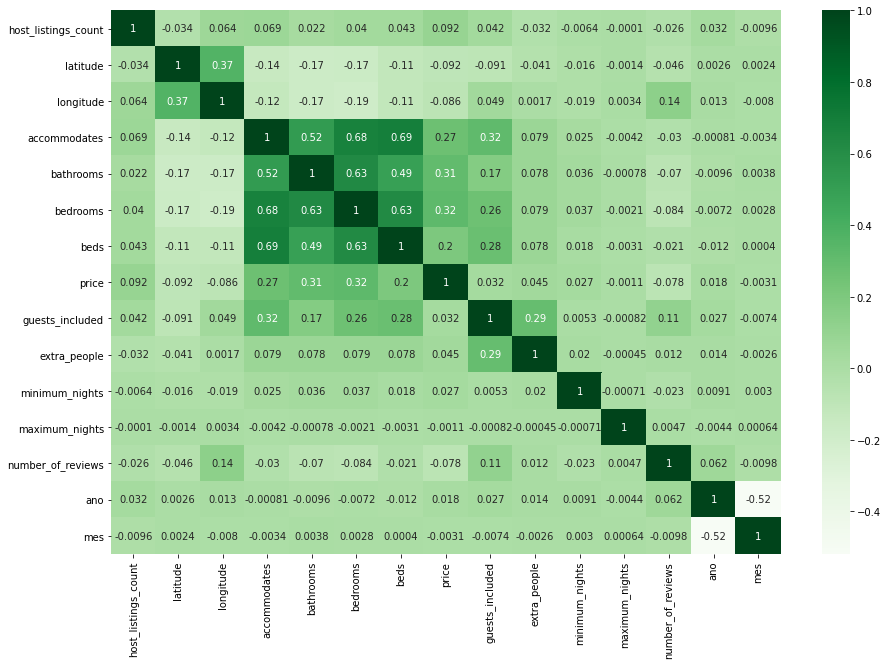

In [13]:
# Mapa de calor ainda ajuda a confirmar se há duas colunas iguais visto que só pode haver 1 na diagonal principal da matriz (Teria algum 1 aleatório no mapa)

plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')
print(base_airbnb.corr())

Correlação negativa: grandezas inversamente proporcionais
Correlação positiva: grandezas diretamente proporcionais

### Definição de Funções para Análise de Outliers

In [14]:
# Identificar Outliers

def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
    
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

In [15]:
# Criação de gráficos

def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### **price**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



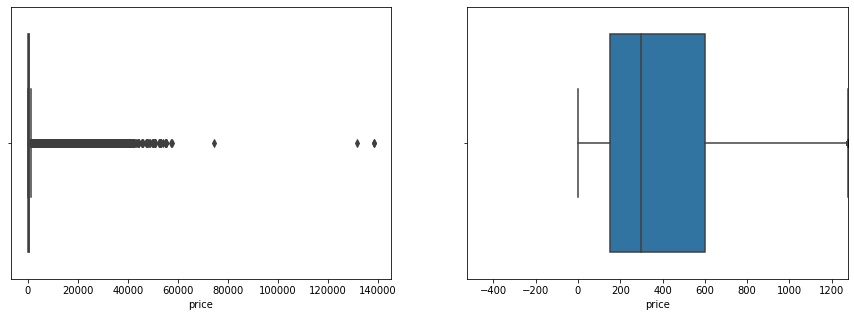

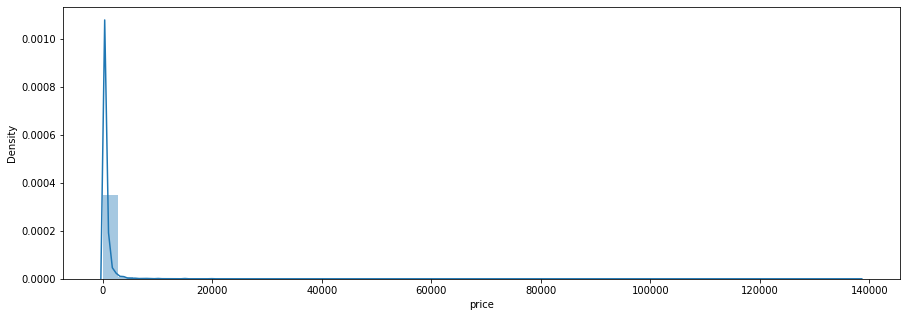

In [16]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [17]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



(810427, 23)


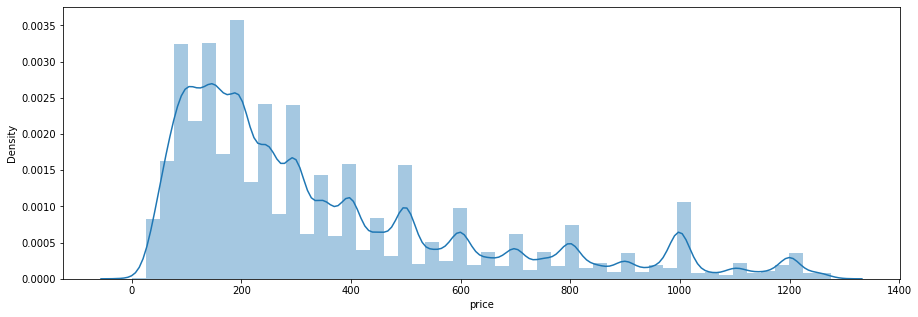

In [18]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### **extra_people**


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



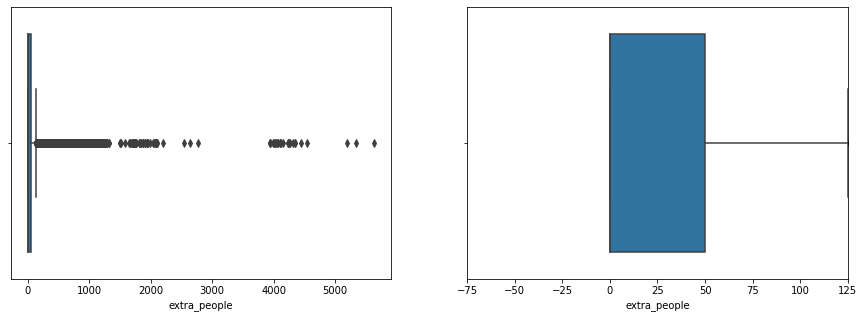

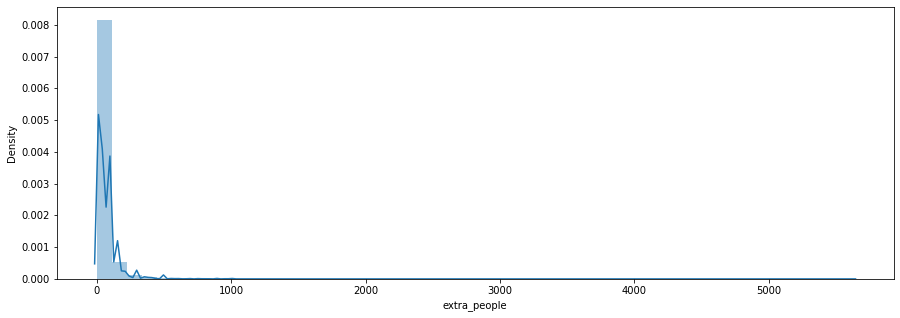

In [19]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [20]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



(751233, 23)


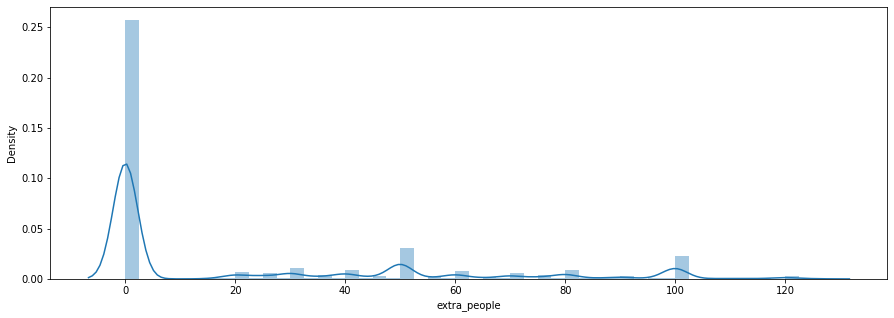

In [21]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### **host_listings_count**

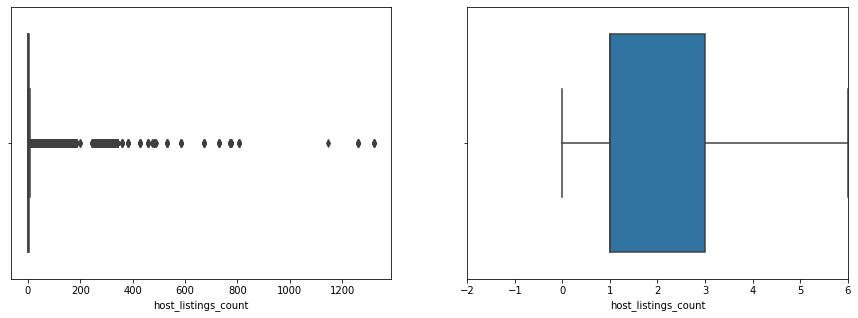

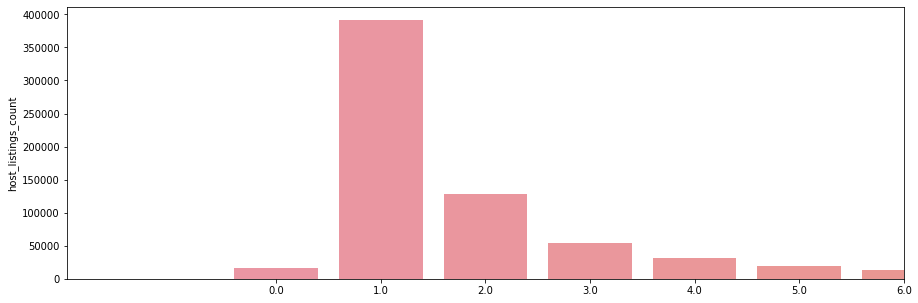

In [22]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


### **accommodates**

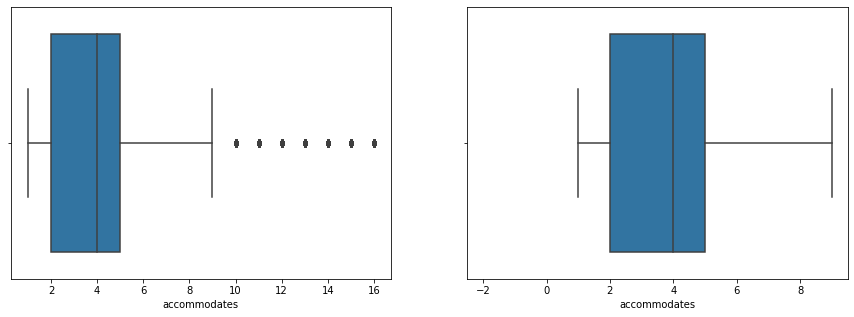

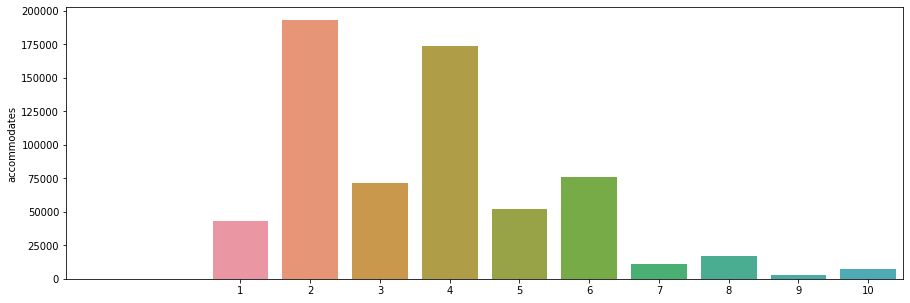

In [24]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

- Pelo mesmo motivo do "host_listings_count" vamos excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

- Caso a gente quisesse incluir apartamentos de alto padrão a gente poderia manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### **bathrooms**

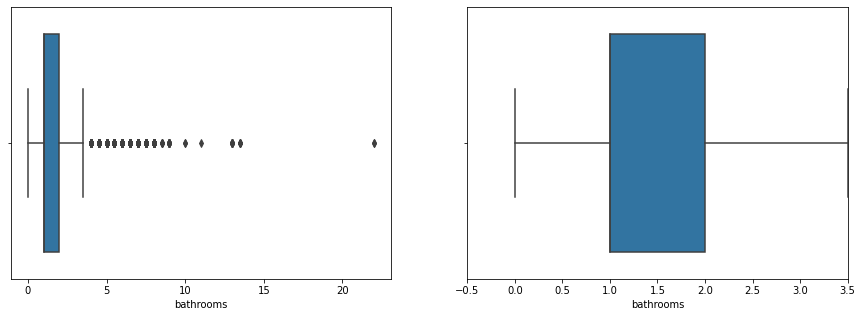

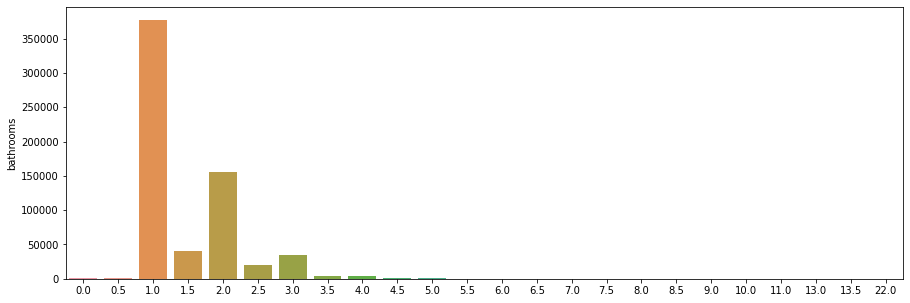

In [26]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

- Pelo mesmo motivo dos anteriores, vamos excluir os outliers nos banheiros

In [27]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### **bedrooms**

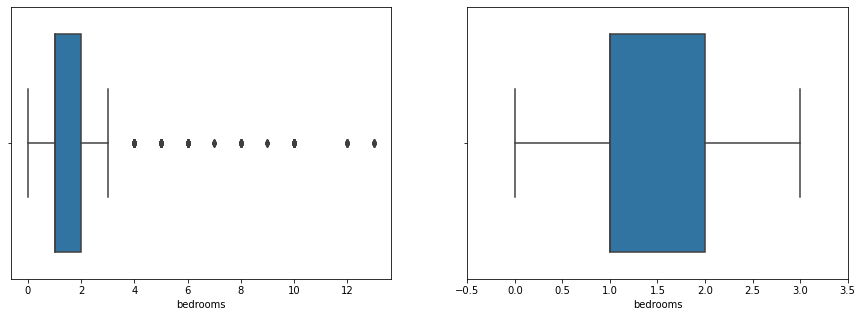

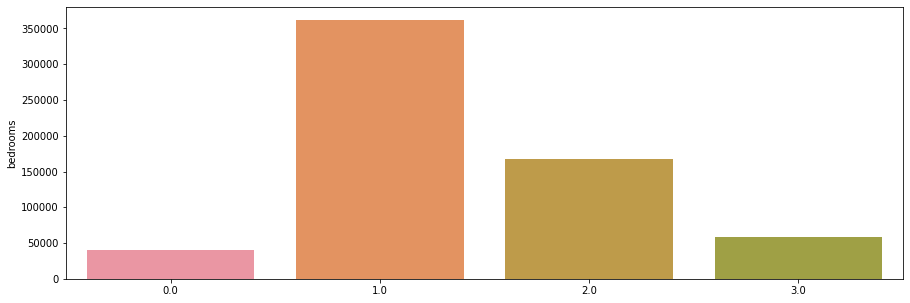

In [28]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de quartos

In [29]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### **beds**

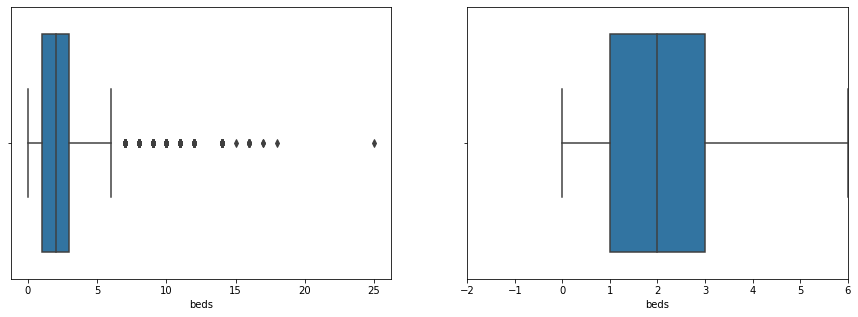

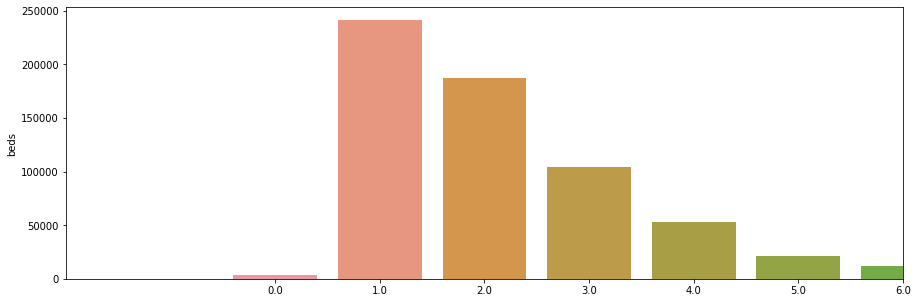

In [30]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de camas


In [31]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### **guests_included**

(1.0, 1.0)


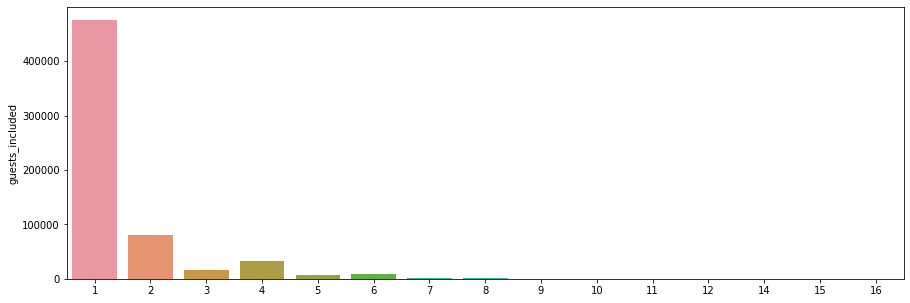

In [32]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [33]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### **minimum_nights**

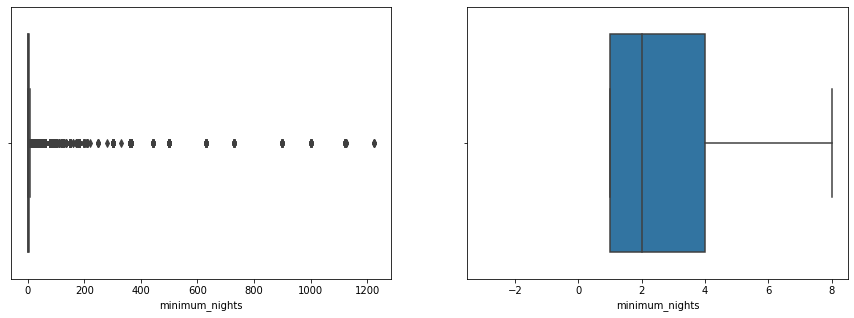

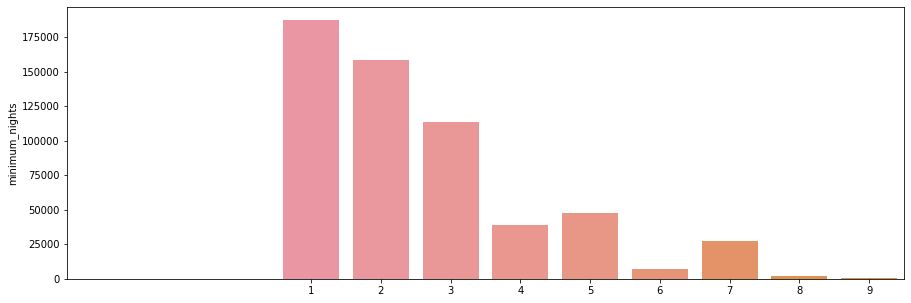

In [34]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [35]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### **maximum_nights**

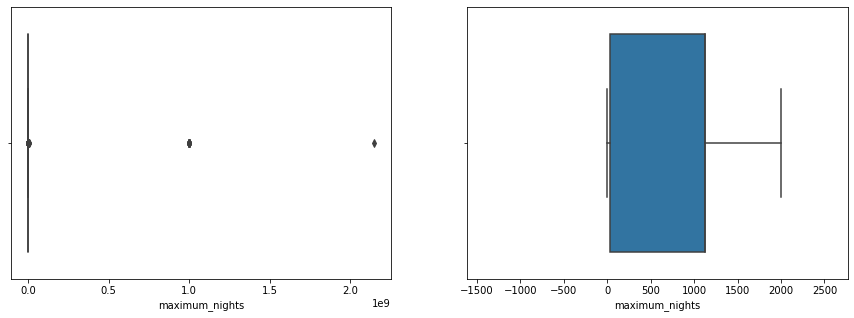

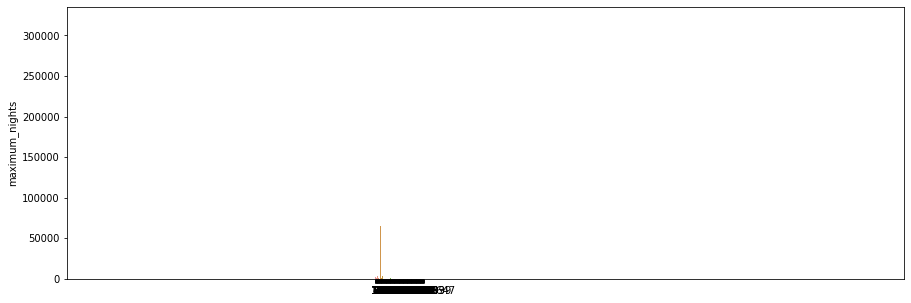

In [36]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

In [37]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### **number_of_reviews**

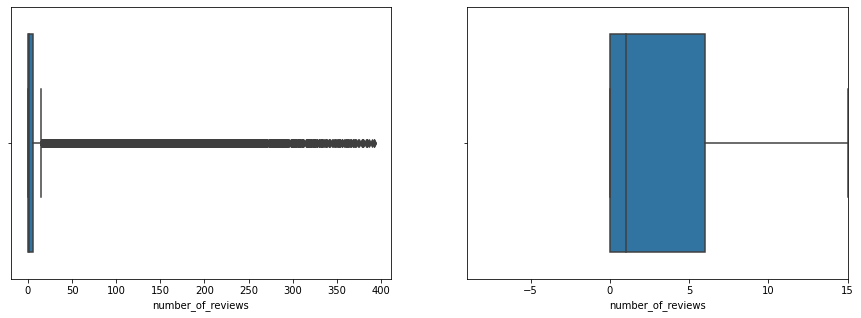

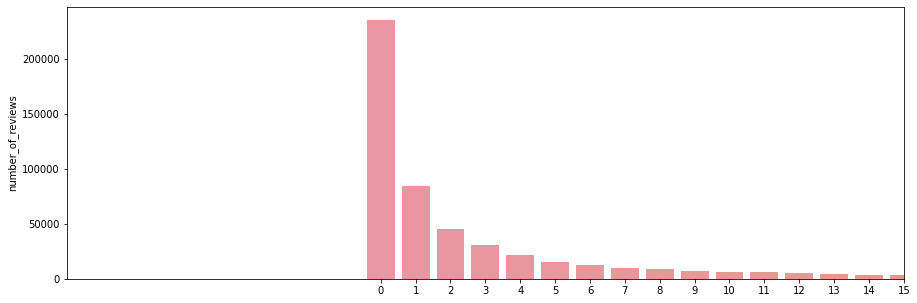

In [38]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou tomar uma decisão baseado na minha análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se excluirmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no nosso objetivo, se eu tenho um imóvel parado e quero colocar meu imóvel lá, é claro que eu não tenho review nenhuma. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final

In [39]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### **Tratamento de Colunas de Valores de Texto**

### **property_type**

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



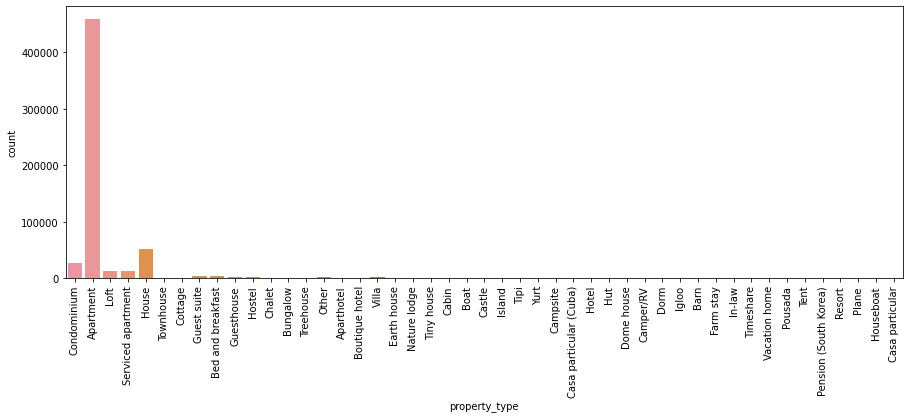

In [40]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Aqui a nossa ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Todos os tipos de propriedade que têm menos de 2.000 propriedades na base de dados, eu vou agrupar em um grupo chamado "outros". Acho que isso vai facilitar o nosso modelo

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'In-law', 'Igloo', 'Vacation home', 'Houseboat', 'Pousada', 'Timeshare', 'Casa particular', 'Plane']
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



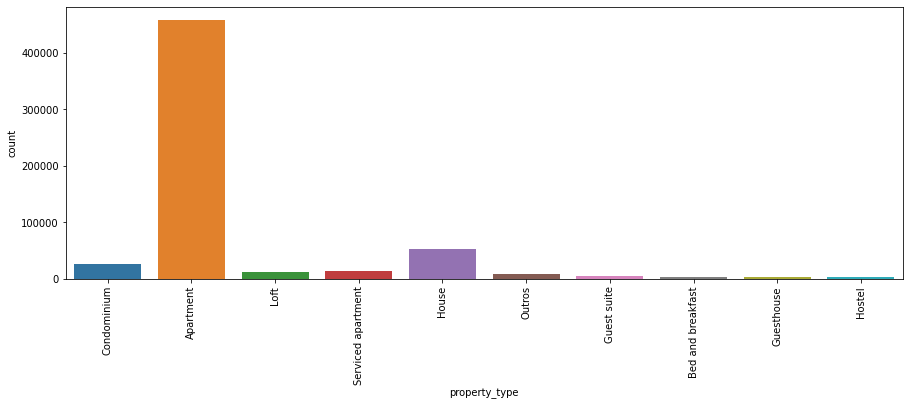

In [41]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### **room_type**

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



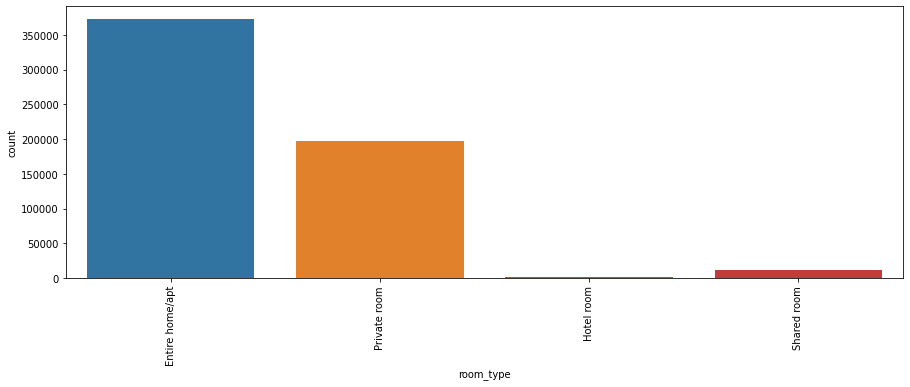

In [42]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

Em tipo de quarto, não precisamos fazer nada, ele já parece estar bem distribuído

### **bed_type**

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



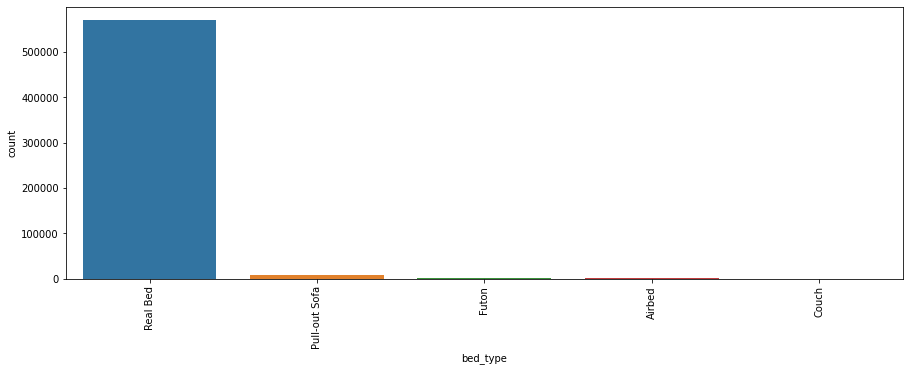

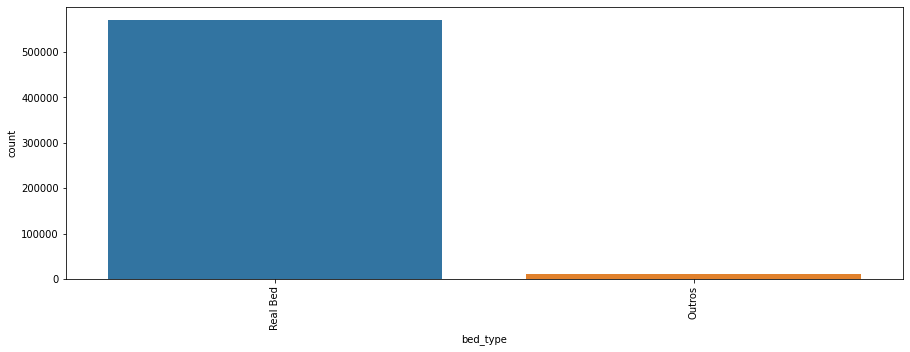

In [43]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

# agrupando categorias de bed_type
tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Aqui a nossa ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Como temos 1 valor claramente MUITO maior do que todos os outros, vou criar apenas 2 grupos de camas: "Real Bed" e "outros"

Isso vai simplificar o modelo

### **cancellation_policy**

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



['strict', 'super_strict_60', 'super_strict_30']
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



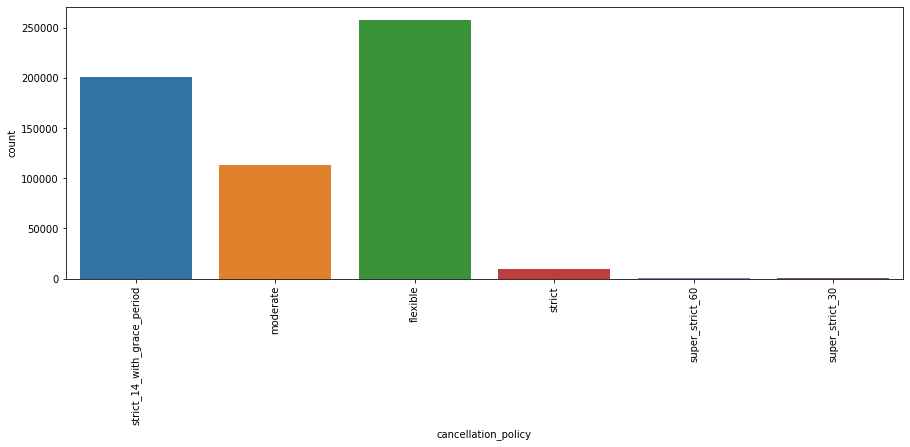

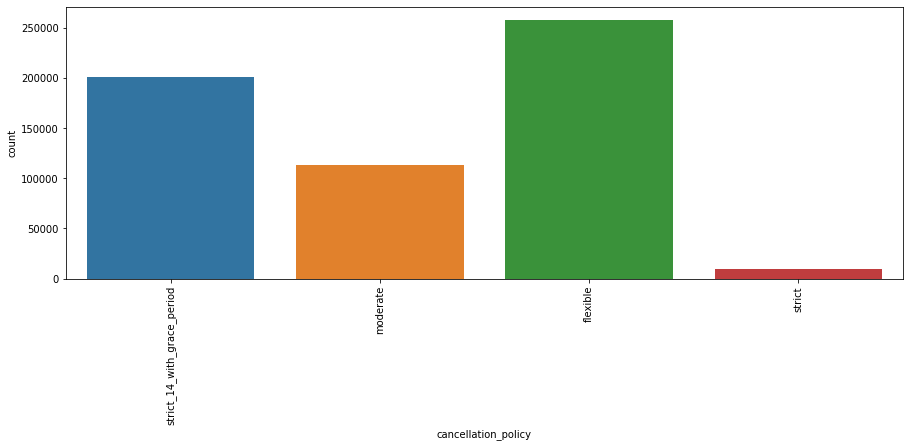

In [44]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

# agrupando categorias de cancellation_pollicy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### **amenities**

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [45]:
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [46]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

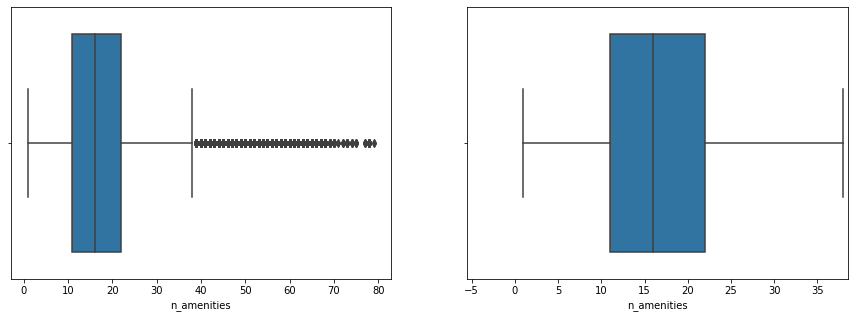

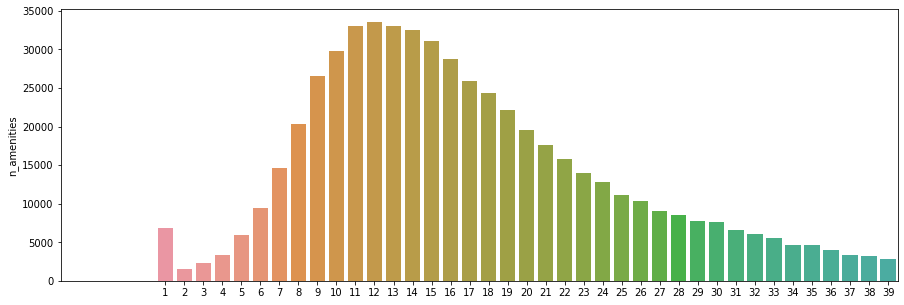

In [47]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

Então, essa virou uma coluna de valor numérico e, como todas as outras colunas de valores numéricos, eu exclui outliers com os mesmos modelos anteriores

In [48]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


### **Visualização de Mapa das Propriedades**

Vamos criar um mapa que exibe um pedaço da nossa base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [49]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

## 5 - Encoding


Precisamor Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

**Criar Variáveis Dummies (Transformar textos em números)**

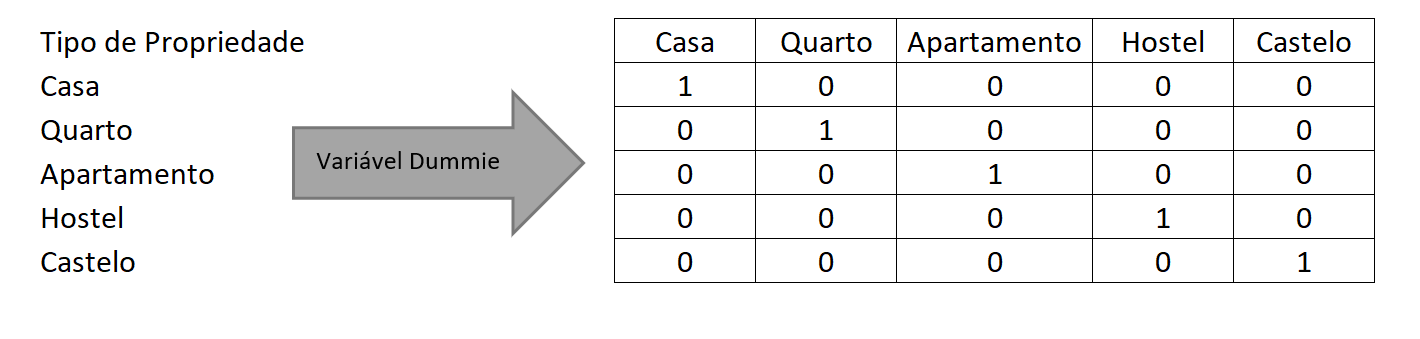

In [50]:
# Colunas verdadeiros e falsos -> 1 e 0
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [51]:
# Variável Dummie
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,ano,mes,n_amenities,property_type_Apartment,property_type_Bed and breakfast,property_type_Condominium,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Loft,property_type_Outros,property_type_Serviced apartment,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outros,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
0,1,2.0,-22.96592,-43.17896,5,1.0,2.0,2.0,329.0,62.0,4,1,0,2019,9,33,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1,0,3.0,-22.97712,-43.19045,3,1.0,1.0,2.0,158.0,45.0,7,0,0,2019,9,14,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
2,1,1.0,-22.98302,-43.21427,3,1.0,1.0,2.0,270.0,42.0,2,1,0,2019,9,25,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3,1,1.0,-22.98816,-43.19359,3,1.5,1.0,2.0,374.0,62.0,2,0,0,2019,9,31,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
16,0,2.0,-22.92873,-43.17473,4,2.0,3.0,4.0,258.0,0.0,4,0,0,2019,9,22,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1


## 6 - Modelo de Previsão 

Passo a Passo:

6.1 - Métricas de Avaliação do Modelo 

6.2 - Escolha dos Modelos 

6.3 - Treinar Modelo 


- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

In [52]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

Assim, escolhemos esses 3 modelos. Existem dezenas, ou até centenas de modelos diferentes. A medida com que você for aprendendo mais e mais sobre Ciência de Dados, você vai aprender sempre novos modelos e entendendo aos poucos qual o melhor modelo para usar em cada situação.

Mas na dúvida, esses 3 modelos que usamos aqui são bem bons para muitos problemas de Regressão.

In [53]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

- Separa os dados em treino e teste + Treino do Modelo

Essa etapa é crucial. As Inteligências Artificiais aprendendo com o que chamamos de treino.

Basicamente o que a gente faz é: a gente separa as informações em treino e teste, ex: 10% da base de dados vai servir para teste e 90% para treino (normalmente treino é maior mesmo)

Aí, damos para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços.

Depois que ele aprende, você faz um teste com ele, com os dados de teste, para ver se ela está bom ou não. Analisando os dados de teste você descobre o melhor modelo

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

t0 = time.time()

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

tf = time.time()

print("Demorou", (round((tf-t0)/60, 2)), "minutos para treinar o modelo")

Modelo RandomForest:
R²:97.20%
RSME:44.14
Modelo LinearRegression:
R²:32.69%
RSME:216.30
Modelo ExtraTrees:
R²:97.51%
RSME:41.59
Demorou 9.8425 minutos para importar os dados


### Análise do Melhor Modelo

In [55]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.20%
RSME:44.14
Modelo LinearRegression:
R²:32.69%
RSME:216.30
Modelo ExtraTrees:
R²:97.51%
RSME:41.59


- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²:97.49%<br>
RSME:41.99

### Ajustes e Melhorias no Melhor Modelo

,0
bedrooms,0.104948
latitude,0.104052
longitude,0.102010
n_amenities,0.088776
extra_people,0.085222
accommodates,0.073717
room_type_Entire home/apt,0.072972
bathrooms,0.071970
minimum_nights,0.065525
beds,0.052608


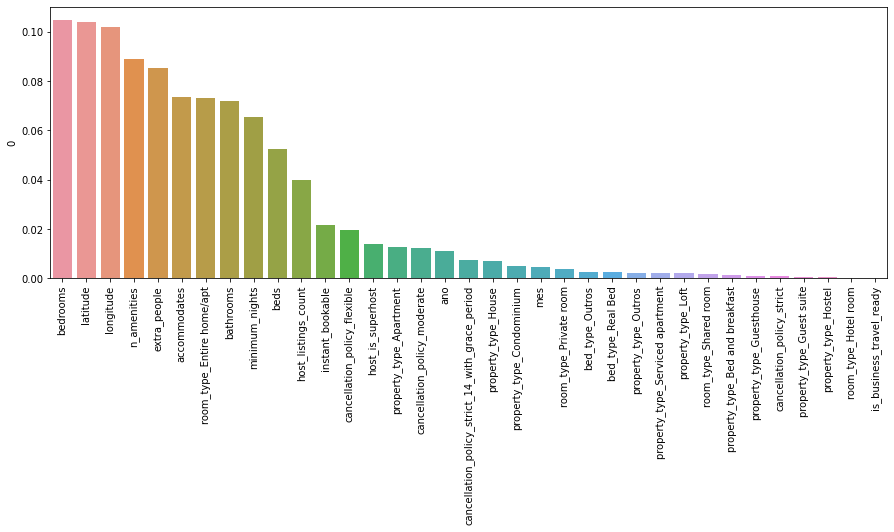

In [56]:
#print(modelo_et.feature_importances_)
#print(X_train.columns)
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo

- is_business_travel ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [57]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.51%
RSME:41.61


In [58]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:    
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)
y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo ExtraTrees:
R²:97.50%
RSME:41.67


In [59]:
print(previsao)

[125.4  264.37 177.83 ... 298.42 146.9  157.64]
